# Research Question 8

8. How do healthcare access and quality compare in each state, including the number of hospitals and health insurance coverage rates?

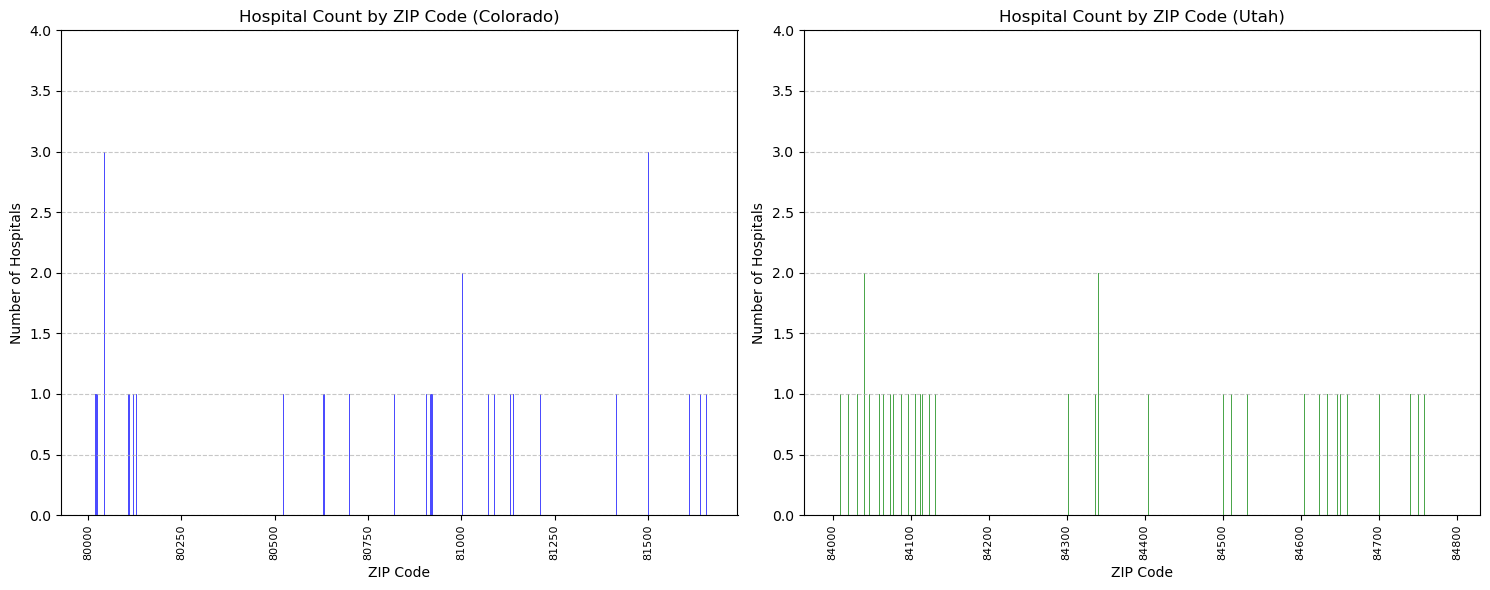

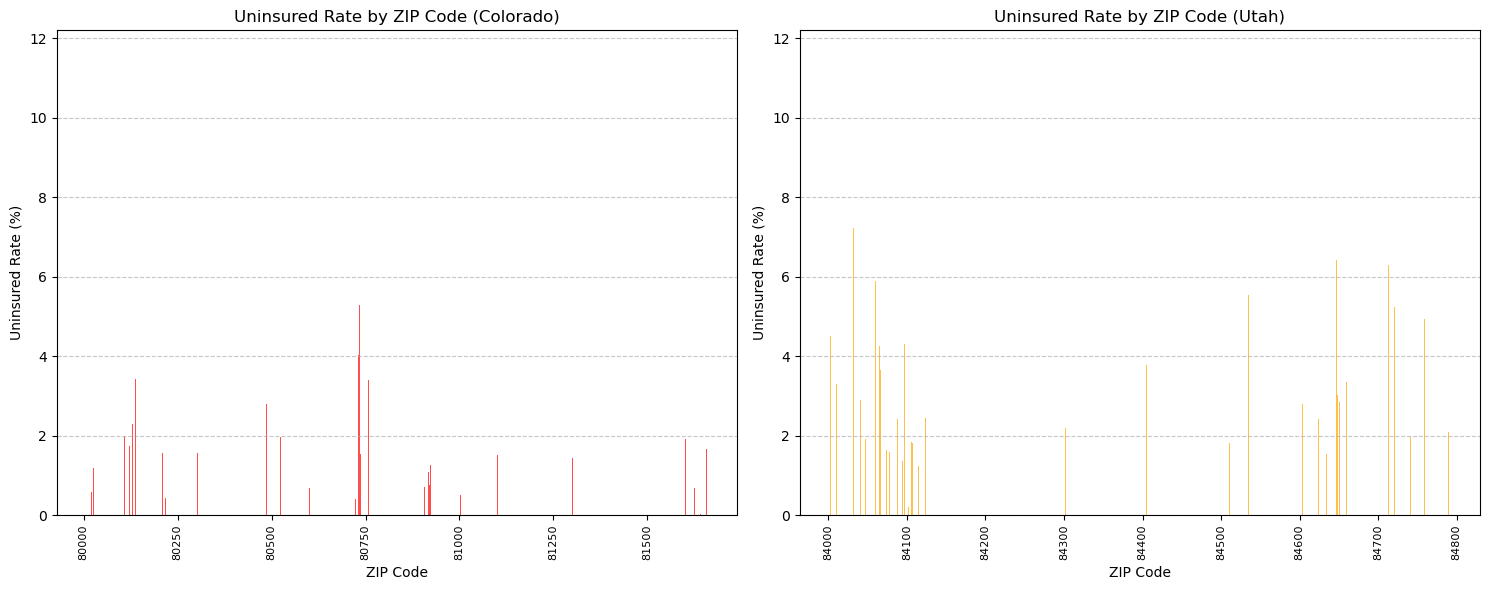

Maps saved: ../results/question_8/interactive_hospital_map.html and ../results/question_8/interactive_uninsured_map.html


In [1]:
import os
from IPython.display import display
import requests
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from io import StringIO
import pgeocode

# Ensure results directory exists
output_dir = "../results/question_8"
os.makedirs(output_dir, exist_ok=True)

### 1. Fetch Hospital Data ###
def get_hospital_data():
    url = 'https://data.cms.gov/provider-data/api/1/datastore/query/xubh-q36u/0/download?format=csv'
    response = requests.get(url)

    if response.status_code == 200:
        csv_data = StringIO(response.text)
        df = pd.read_csv(csv_data)
    else:
        print(f"Error fetching CMS data, Status Code: {response.status_code}")
        return None

    raw_data = df

    df["State"] = df["State"].astype(str).str.upper()
    df = df.dropna(subset=["ZIP Code"])
    df["ZIP Code"] = df["ZIP Code"].astype(str).str.extract(r"(\d+)").astype(float).astype("Int64")
    df = df[df["State"].isin(["CO", "UT"])]

    hospital_count = df.groupby(["State", "ZIP Code"])["Facility ID"].count().reset_index()
    hospital_count.columns = ["State", "ZIP_Code", "Hospital_Count"]

    return raw_data, hospital_count

### 2. Fetch Health Insurance Coverage Data ###
def get_health_insurance_data(year=2022):
    url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,B27010_001E,B27010_005E&for=zip code tabulation area:*"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data[1:], columns=data[0])

        raw_data = df

        df["Total_Population"] = df["B27010_001E"].astype(int)
        df["Uninsured_Population"] = df["B27010_005E"].astype(int)
        df["Uninsured_Rate"] = df["Uninsured_Population"] / df["Total_Population"] * 100

        df.rename(columns={"zip code tabulation area": "ZIP_Code"}, inplace=True)
        df = df[df["ZIP_Code"].astype(int).between(80000, 81699) | df["ZIP_Code"].astype(int).between(84000, 84799)]

        return raw_data, df[["ZIP_Code", "Uninsured_Rate"]]
    else:
        print(f"Error fetching ACS data, Status Code: {response.status_code}")
        return None

### 3. Convert ZIP Codes to Latitude/Longitude ###
def get_lat_lon(zip_code):
    nomi = pgeocode.Nominatim("us")
    location = nomi.query_postal_code(str(zip_code))

    if pd.notna(location.latitude) and pd.notna(location.longitude):
        return location.latitude, location.longitude
    return None, None

### 4. Process and Merge Data ###
before_hospital_data, hospital_data = get_hospital_data()
before_health_insurance_data, health_insurance_data = get_health_insurance_data()

if hospital_data is not None and health_insurance_data is not None:
    hospital_data["ZIP_Code"] = hospital_data["ZIP_Code"].astype(int)
    health_insurance_data["ZIP_Code"] = health_insurance_data["ZIP_Code"].astype(int)

    merged_data = pd.merge(hospital_data, health_insurance_data, on="ZIP_Code", how="outer").fillna(0)
    merged_data = merged_data.sort_values(by="ZIP_Code")

    # Separate data for Colorado (CO) and Utah (UT)
    merged_data_CO = merged_data[merged_data["State"] == "CO"]
    merged_data_UT = merged_data[merged_data["State"] == "UT"]

    # Get maximum values to standardize y-axis scale
    max_hospitals = max(merged_data_CO["Hospital_Count"].max(), merged_data_UT["Hospital_Count"].max())
    max_uninsured = max(merged_data_CO["Uninsured_Rate"].max(), merged_data_UT["Uninsured_Rate"].max())

    ### 5. Generate Bar Graphs ###
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Colorado - Hospital Count
    axes[0].bar(merged_data_CO["ZIP_Code"], merged_data_CO["Hospital_Count"], color='b', alpha=0.7)
    axes[0].set_xlabel("ZIP Code")
    axes[0].set_ylabel("Number of Hospitals")
    axes[0].set_title("Hospital Count by ZIP Code (Colorado)")
    axes[0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0].grid(axis='y', linestyle="--", alpha=0.7)
    axes[0].set_ylim(0, max_hospitals + 1)

    # Utah - Hospital Count
    axes[1].bar(merged_data_UT["ZIP_Code"], merged_data_UT["Hospital_Count"], color='g', alpha=0.7)
    axes[1].set_xlabel("ZIP Code")
    axes[1].set_ylabel("Number of Hospitals")
    axes[1].set_title("Hospital Count by ZIP Code (Utah)")
    axes[1].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1].grid(axis='y', linestyle="--", alpha=0.7)
    axes[1].set_ylim(0, max_hospitals + 1)

    # Save hospital count graph
    plt.tight_layout()
    plt.savefig(f"{output_dir}/hospital_count_graph.png")
    plt.show()
    plt.close('all')

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Colorado - Uninsured Rate
    axes[0].bar(merged_data_CO["ZIP_Code"], merged_data_CO["Uninsured_Rate"], color='r', alpha=0.7)
    axes[0].set_xlabel("ZIP Code")
    axes[0].set_ylabel("Uninsured Rate (%)")
    axes[0].set_title("Uninsured Rate by ZIP Code (Colorado)")
    axes[0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0].grid(axis='y', linestyle="--", alpha=0.7)
    axes[0].set_ylim(0, max_uninsured + 1)

    # Utah - Uninsured Rate
    axes[1].bar(merged_data_UT["ZIP_Code"], merged_data_UT["Uninsured_Rate"], color='orange', alpha=0.7)
    axes[1].set_xlabel("ZIP Code")
    axes[1].set_ylabel("Uninsured Rate (%)")
    axes[1].set_title("Uninsured Rate by ZIP Code (Utah)")
    axes[1].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1].grid(axis='y', linestyle="--", alpha=0.7)
    axes[1].set_ylim(0, max_uninsured + 1)

    # Save uninsured rate graph
    plt.tight_layout()
    plt.savefig(f"{output_dir}/uninsured_rate_graph.png")
    plt.show()
    plt.close('all')

    # Convert ZIP codes to latitude and longitude
    merged_data["Latitude"], merged_data["Longitude"] = zip(*merged_data["ZIP_Code"].apply(get_lat_lon))
    merged_data = merged_data.dropna(subset=["Latitude", "Longitude"])

    ### 6. Generate Interactive Hospital Count Map ###
    map_hospitals = folium.Map(location=[39.5, -106.0], zoom_start=6, tiles="CartoDB positron")
    hospital_cluster = MarkerCluster().add_to(map_hospitals)

    for _, row in merged_data.iterrows():
        popup_info = f"""
        <b>ZIP Code:</b> {row['ZIP_Code']}<br>
        <b>Hospitals:</b> {row['Hospital_Count']}
        """

        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            icon=folium.DivIcon(html=f'''
                <div style="
                    font-size: 10pt; 
                    color: white; 
                    background: blue; 
                    padding: 3px; 
                    border-radius: 5px;
                    text-align: center;
                    font-weight: bold;">
                    {row["Hospital_Count"]}
                </div>'''),
            popup=popup_info
        ).add_to(hospital_cluster)

    ### 7. Generate Interactive Uninsured Rate Map ###
    map_uninsured = folium.Map(location=[39.5, -106.0], zoom_start=6, tiles="CartoDB positron")
    uninsured_cluster = MarkerCluster().add_to(map_uninsured)

    for _, row in merged_data.iterrows():
        popup_info = f"""
        <b>ZIP Code:</b> {row['ZIP_Code']}<br>
        <b>Uninsured Rate:</b> {row['Uninsured_Rate']:.1f}%
        """

        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            icon=folium.DivIcon(html=f'''
                <div style="
                    font-size: 10pt; 
                    color: white; 
                    background: red; 
                    padding: 3px; 
                    border-radius: 5px;
                    text-align: center;
                    font-weight: bold;">
                    {row["Uninsured_Rate"]:.1f}%
                </div>'''),
            popup=popup_info
        ).add_to(uninsured_cluster)

    # Save maps
    map_hospitals.save(f"{output_dir}/interactive_hospital_map.html")
    map_uninsured.save(f"{output_dir}/interactive_uninsured_map.html")

    print(f"Maps saved: {output_dir}/interactive_hospital_map.html and {output_dir}/interactive_uninsured_map.html")

## Before and After Snapshots of the Dataset

In [2]:
# before hosptial data
before_hospital_data.head()

,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,1,8,2,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN


In [3]:
# after hosptial data
hospital_data.head()

,State,ZIP_Code,Hospital_Count
0,CO,80012,1
1,CO,80021,1
2,CO,80023,1
3,CO,80026,1
4,CO,80027,2


In [4]:
# before health insurance data
before_health_insurance_data.head()

,NAME,B27010_001E,B27010_005E,ZIP_Code,Total_Population,Uninsured_Population,Uninsured_Rate
0,ZCTA5 00601,16791,129,00601,16791,129,0.768269
1,ZCTA5 00602,37575,393,00602,37575,393,1.045908
2,ZCTA5 00603,48355,480,00603,48355,480,0.992658
3,ZCTA5 00606,5590,0,00606,5590,0,0.000000
4,ZCTA5 00610,25446,175,00610,25446,175,0.687731


In [5]:
# after health insurance data
health_insurance_data.head()

,ZIP_Code,Uninsured_Rate
28345,80002,0.461568
28346,80003,1.269955
28347,80004,1.082301
28348,80005,1.329075
28349,80007,1.360467
